In [188]:
import polars as pl

In [189]:
all_prices = pl.read_csv("./data/reinforcement_all_prices.csv")
all_prices.head(3)

,basis,product,value_date,category,region,value,dt
i64,str,str,str,str,str,f64,str
0,"""Средневзвешенная цена окатыши …","""ЖРС""","""2018-01-01""","""Сырье""","""Внутренние рынки""",4239.0,"""2018-01-01"""
1,"""Средневзвешенная цена концентр…","""ЖРС""","""2018-01-01""","""Сырье""","""Внутренние рынки""",3100.0,"""2018-01-01"""
2,"""Средневзвешенная цена аглоруда…","""ЖРС""","""2018-01-01""","""Сырье""","""Внутренние рынки""",1863.0,"""2018-01-01"""


In [190]:
all_prices.null_count()

,basis,product,value_date,category,region,value,dt
u32,u32,u32,u32,u32,u32,u32,u32
0,1464,0,0,0,0,12183,0


In [191]:
cis_export = pl.read_csv("./data/reinforcement_cis_export.csv")
cis_export.head(3)

country,supplier_customer,product,subproduct,value_date,category,value
str,str,str,str,str,str,f64
"""Не определено""","""Лебединский ГОК""","""Металлизованная продукция""","""Всего отгружено с предприятия""","""2018-01-01""","""Экспорт->Россия->Сырье""",333.0
"""Нидерланды""","""Лебединский ГОК""","""Металлизованная продукция""","""ГБЖ""","""2018-01-01""","""Экспорт->Россия->Сырье""",0.0
"""Беларусь""","""Лебединский ГОК""","""Металлизованная продукция""","""ГБЖ""","""2018-01-01""","""Экспорт->Россия->Сырье""",20.0


In [192]:
cis_export.null_count()

country,supplier_customer,product,subproduct,value_date,category,value
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,15131


In [193]:
cis_import = pl.read_csv("./data/reinforcement_cis_import.csv")
cis_import.head(3)

country,supplier_customer,product,subproduct,value_date,category,value,dt
str,str,str,str,str,str,f64,str
"""Казахстан""","""ЕВРАЗ-ЗСМК""","""ЖРС""","""Концентрат""","""2018-01-01""","""Импорт->Россия->Сырье""",0.0,"""2018-01-01"""
"""Казахстан""","""Магнитогорский МК""","""ЖРС""","""Концентрат""","""2018-01-01""","""Импорт->Россия->Сырье""",415.0,"""2018-01-01"""
"""Казахстан""","""Новолипецкий МК""","""ЖРС""","""Концентрат""","""2018-01-01""","""Импорт->Россия->Сырье""",0.0,"""2018-01-01"""


In [194]:
cis_import.null_count()

country,supplier_customer,product,subproduct,value_date,category,value,dt
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,5650,0


In [195]:
consumption = pl.read_csv("./data/reinforcement_consumption.csv")
consumption.head(3)

product,subproduct,value_date,category,subcategory,value,dt
str,str,str,str,str,f64,str
"""Концентрат""",null,"""2021-07-01""","""Россия->Сырье""","""ЖРС""",3780.0,"""2021-07-01"""
"""Агломерат""",null,"""2021-07-01""","""Россия->Сырье""","""ЖРС""",334.0,"""2021-07-01"""
"""Окатыши""",null,"""2021-07-01""","""Россия->Сырье""","""ЖРС""",2969.0,"""2021-07-01"""


In [196]:
consumption.null_count()

product,subproduct,value_date,category,subcategory,value,dt
u32,u32,u32,u32,u32,u32,u32
0,756,0,0,0,108,0


In [197]:
domestic = pl.read_csv("./data/reinforcement_domestic_supplies.csv")
domestic.head(3)

product,subproduct,value_date,category,value,supplier_customer,consumer_supplier
str,str,str,str,f64,str,str
"""ЖРС""","""Концентрат""","""2018-01-01""","""Потребители->Казахстан->Сырье""",150.0,"""АрселорМиттал Темиртау""","""Соколовско-Сарбайское ГПО"""
"""ЖРС""","""Окатыши""","""2018-01-01""","""Потребители->Казахстан->Сырье""",95.0,"""АрселорМиттал Темиртау""","""Соколовско-Сарбайское ГПО"""
"""ЖРС""","""Агломерат""","""2018-01-01""","""Потребители->Украина->Сырье""",379.0,"""Азовсталь""","""Мариупольский МК им. Ильича"""


In [198]:
domestic.null_count()

product,subproduct,value_date,category,value,supplier_customer,consumer_supplier
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,12608,0,0


In [199]:
prices = pl.read_csv("./data/reinforcement_prices.csv")
prices.head(3)

,dt,price_reinforcement_a500c_12mm_fca_Moscow
i64,str,f64
0,"""2018-01-01""",35600.0
1,"""2018-01-08""",35600.0
2,"""2018-01-15""",35300.0


In [200]:
prices.null_count()

,dt,price_reinforcement_a500c_12mm_fca_Moscow
u32,u32,u32
0,0,0


In [201]:
production = pl.read_csv("./data/reinforcement_production.csv")
production.head(3)

country,manufacturer,product,subproduct,value_date,category,value
str,str,str,str,str,str,f64
"""Россия""","""Лебединский ГОК""","""Металлизованная продукция""","""ГБЖ""","""2018-01-01""","""Сырье""",425.0
"""Россия""","""Оскольский ЭМК""","""Металлизованная продукция""","""ПВЖ""","""2018-01-01""","""Сырье""",286.0
"""Россия""","""Белон""","""Рядовой коксующийся уголь""","""Жирные""","""2018-01-01""","""Сырье""",159.0


In [202]:
production.null_count()

country,manufacturer,product,subproduct,value_date,category,value
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,724


# Начало

## Ряд

            Unnamed: 0  target_price
dt                                  
2018-01-01           0       35600.0
2018-01-08           1       35600.0
2018-01-15           2       35300.0
2018-01-22           3       34500.0
2018-01-29           4       33700.0


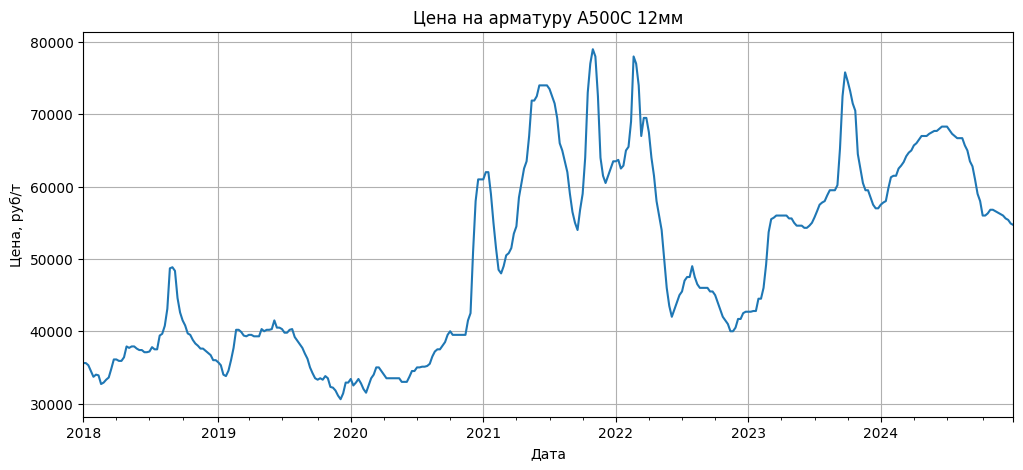

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

df_price = pd.read_csv("./data/reinforcement_prices.csv")
df_price['dt'] = pd.to_datetime(df_price['dt'])
df_price = df_price.set_index('dt').sort_index()
df_price = df_price.rename(columns={"price_reinforcement_a500c_12mm_fca_Moscow": "target_price"})

print(df_price.head())

df_price['target_price'].plot(figsize=(12, 5), title="Цена на арматуру A500C 12мм")
plt.ylabel("Цена, руб/т")
plt.xlabel("Дата")
plt.grid(True)
plt.show()

## all_prices features

In [204]:
df_quotes = pd.read_csv("data/reinforcement_all_prices.csv")

df_quotes['value_date'] = pd.to_datetime(df_quotes['value_date'])
fill_values = [
    'Cырье_концентрат_коксующегося_угля1', 
    'Cырье_концентрат_коксующегося_угля2', 
    'Cырье_концентрат_коксующегося_угля3',
    'Cырье_концентрат_коксующегося_угля4'
]
nan_indices = df_quotes[df_quotes['basis'].isna()].index

for i, idx in enumerate(nan_indices):
    df_quotes.loc[idx, 'basis'] = fill_values[i % len(fill_values)]

df_quotes = df_quotes[['basis', 'value_date',  'value']]
df_quotes_wide = df_quotes.pivot_table(index='value_date', columns='basis', values='value').sort_index()

убираем, где дофига пропущено, остальные линейно интерполируем

In [205]:
target = df_quotes_wide["Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС"]
# df_quotes_wide.drop("Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС", axis=1, inplace=True)

missing_values = df_quotes_wide.isna().sum()
threshold = 0.3
df_wide_clean = df_quotes_wide.loc[:, missing_values / len(df_quotes_wide) < threshold]
df_wide_clean = df_wide_clean.interpolate(method='linear', limit_direction='both')

In [206]:
df = df_wide_clean
df.to_csv('test1.csv')

сдвигаю все на 1, назад, так как нам известны только прошлые данные

In [207]:
df = df.shift(1)

добавляю побольше фичей лагов

In [208]:
colnames = list(df.columns)
for col in colnames:
    for i in range(1,8):
        df[f'{col}_{i}'] = df[col].shift(i)

/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_4980/167153264.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_4980/167153264.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_4980/167153264.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [209]:
df['target'] = target

/var/folders/y5/dqknd6mj4l965pqd1q8tspvm0000gn/T/ipykernel_4980/2181671267.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = target


In [210]:
df = df.dropna()

## простые мл модели

In [211]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge

In [212]:
def train_and_test(df, models, colors, pred_size):
    test = df.tail(pred_size)
    train = df.iloc[:-pred_size]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions[name] = pred

    for name, pred in predictions.items():
        mae = mean_absolute_error(y_test, pred)
        rmse = root_mean_squared_error(y_test, pred)
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
    colors = ['red', 'green', 'purple', 'yellow']
    for i, model in enumerate(models.keys()):
        plt.plot(test.index, predictions[model], label=model, color=colors[i], linestyle='-', marker='x')
    plt.ylabel("Цена, руб/т")
    plt.xlabel("Дата")
    plt.title("Цена на арматуру A500C 12мм")
    plt.legend()
    plt.grid(True)
    plt.show()


In [213]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(n_estimators=100),
    'Lasso': Lasso(alpha=0.1)
    # 'Ridge': Ridge(alpha=0.1)
}
colors = ['red', 'green', 'purple', 'yellow']

Random Forest -> MAE: 1012.38, RMSE: 1081.75
XGBoost -> MAE: 923.87, RMSE: 1054.84
Lasso -> MAE: 2926.19, RMSE: 3793.06


/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.559e+07, tolerance: 6.080e+06
  model = cd_fast.enet_coordinate_descent(


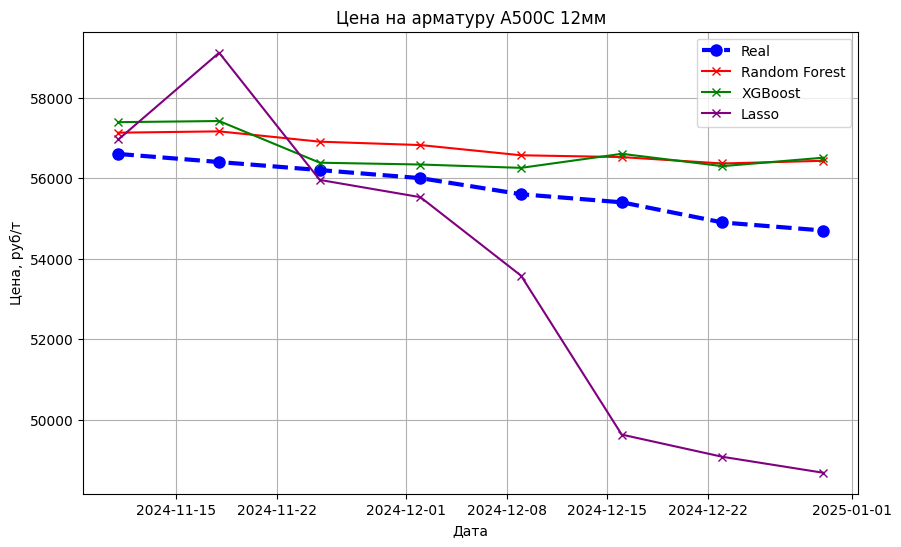

In [214]:
train_and_test(df, models, colors, 8)

Random Forest -> MAE: 1301.72, RMSE: 1509.03
XGBoost -> MAE: 804.12, RMSE: 927.26
Lasso -> MAE: 3249.69, RMSE: 3493.95


/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e+07, tolerance: 6.029e+06
  model = cd_fast.enet_coordinate_descent(


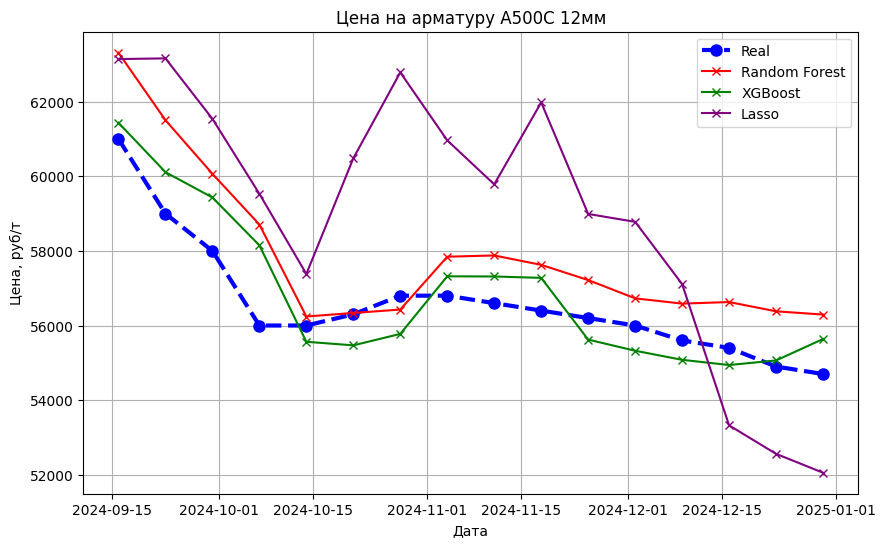

In [215]:
train_and_test(df, models, colors, 16)